# VET Test - Linear field displacement

In this Jupyter notebook, we will test the Variational Echo Tracking implementation using
reference image and a target image that was morphed using a known displacement field.

The VET should be able to retrieve actual displacement field.


## Load reference image
Lets start by loading a reference image from the scipy package and resizing it to a suitable size:

In [1]:
import numpy
from scipy.misc.common import face # import the racoon face image
from skimage import transform 
import matplotlib.pyplot as plt

# Image size to use in the example
image_size = 16 * 4 * 2 * 2

# Lets first convert the color image to grey scale
def rgb2gray(rgb):
    """ Function to convert rgb to grey scale"""
    return numpy.dot(rgb[..., :3], [0.299, 0.587, 0.114])

reference_image = numpy.array(rgb2gray(face()))

# Now resize the image to the desired size
reference_image = transform.resize(
    reference_image, (image_size, image_size), mode='reflect')

# Set the default configurations for figures to be used in this notebook

# Show reference image
plt.figure(figsize=(8, 8))
plt.gray()
plt.imshow(reference_image)
plt.show()

Lets create an imaginary grid on the image and create a displacement field to apply to the image:

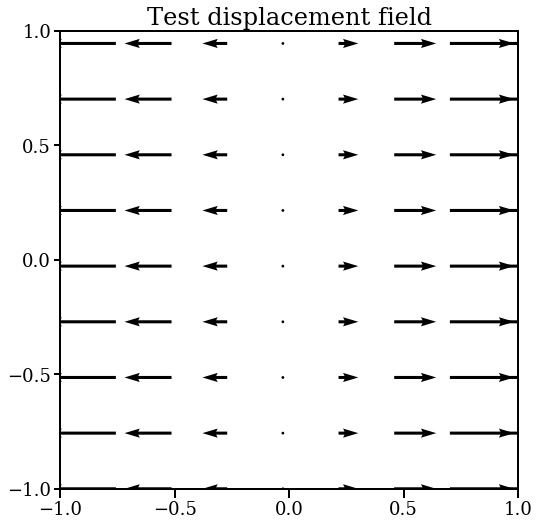

In [2]:
# Set the grid values (x,y) between -1 and 1
positions = numpy.linspace(-1, 1, image_size)
x, y = numpy.meshgrid(positions,
                      positions)

# Create a reference displacement to be applied to the reference image
# A rotor displacement is applied
displacement = numpy.zeros((2, image_size, image_size))

displacement[0, :] = x
displacement[1, :] = 0

displacement *= 2

step = 31

### Set figures default properties
import matplotlib
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 24

plt.close()  # Close previous figures if any
plt.figure(figsize=(8, 8))

plt.quiver(x[::step, ::step], y[::step, ::step],
           displacement[0, ::step, ::step],
           displacement[1, ::step, ::step], scale=10)

plt.title("Test displacement field")
plt.gca().set_aspect('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.show()

## Retrieve displacement field using VET
Now, we apply morph the reference image by appliying the displacement field:    

In [3]:
from pyVET.vet import morph

morphed_image, mask = morph(reference_image, displacement)

Retrieve the displacement field applied to the image using the VET algorithm.

In [5]:
from pyVET.vet import vet

# Scaling procedure factors
# This means that the algorithm will start the minimization using 2x2 sector displacements,
# then, 4x4, and finally 16x16
factors = [2, 4, 8, 16]
#mask = numpy.ones_like(reference_image, dtype=numpy.int8)
new_displacement, intermediate_steps = vet(reference_image,
                                           morphed_image,
                                           mask,
                                           factors,
                                           verbose=True,
                                           intermediate_steps=True,
                                           smooth_gain=100)


Sector Shape: (128, 128)
Minimizing
         Current function value: 11604025.952204
         Iterations: 9
         Function evaluations: 1092
         Gradient evaluations: 108

Sector Shape: (64, 64)
Minimizing
         Current function value: 5828778.487785
         Iterations: 9
         Function evaluations: 2085
         Gradient evaluations: 61

Sector Shape: (32, 32)
Minimizing
         Current function value: 2037928.925740
         Iterations: 5
         Function evaluations: 5991
         Gradient evaluations: 46

Sector Shape: (16, 16)
Minimizing
         Current function value: 932400.135049
         Iterations: 5
         Function evaluations: 24683
         Gradient evaluations: 48


## Show the scaling guess procedure results

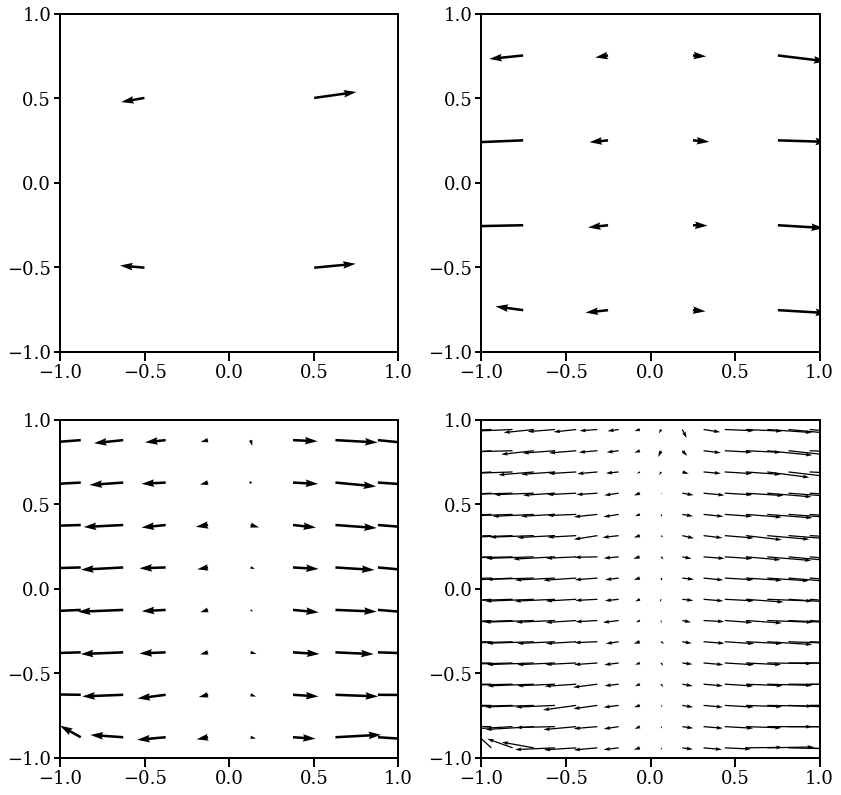

In [6]:
from pyVET.vet import downsize

plt.close()
plt.figure(figsize=(13, 13))

for i, firstGuess in enumerate(intermediate_steps):

    x_factor = reference_image.shape[0] / firstGuess.shape[1]
    y_factor = reference_image.shape[1] / firstGuess.shape[2]

    # Get the positions of each sector's center
    new_x = downsize(x, x_factor, y_factor=y_factor)
    new_y = downsize(y, x_factor, y_factor=y_factor)

    ax = plt.subplot(221 + i, aspect='equal')
    plt.quiver(new_x, new_y, firstGuess[0, ...],
               firstGuess[1, ...], scale=10)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))

plt.show()

## Compare retrieved displacement field with the applied one

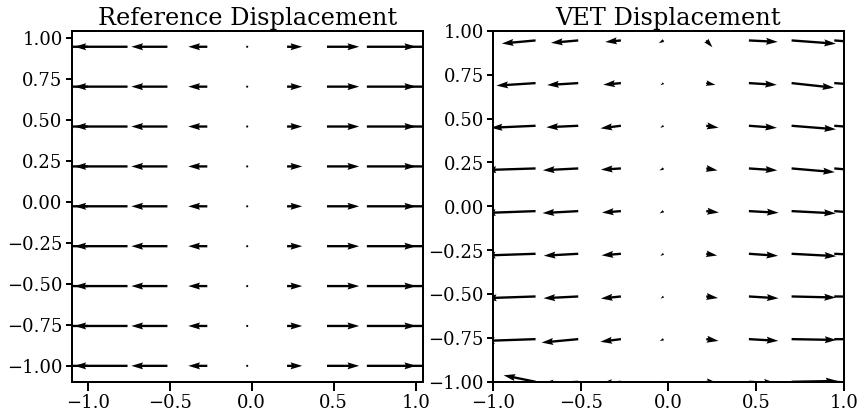

In [9]:
plt.close()
plt.figure(figsize=(13, 13))

plt.subplot(121, aspect='equal')
step = 31
plt.title("Reference Displacement")
plt.quiver(x[::step, ::step], y[::step, ::step],
           displacement[0, ::step, ::step],
           displacement[1, ::step, ::step], scale=10)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.subplot(122, aspect='equal')
plt.title("VET Displacement")
plt.quiver(x[::step, ::step], y[::step, ::step],
           new_displacement[0, ::step, ::step],
           new_displacement[1, ::step, ::step], scale=10)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()


The differences in the fields are mostly because the minimization is never carried out in the grid resultion.
The minimum sector size was 16x16 grid points.